# Exploring enrichment analysis of HL60 response to bendamustine.

This is the second notebook for the Pino Et. Al.
In this notebook we demonstrate how MAGINE can be used to explore the enrichment analysis. 

In [1]:
from IPython.display import display, Image
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.precision', 2)
pd.set_option('display.max_colwidth', 50)
%load_ext autoreload
%autoreload 2

In [2]:
# load magine specific tools
from magine.plotting.wordcloud_tools import create_wordcloud
from magine.plotting.heatmaps import heatmap_by_terms
from magine.plotting.venn_diagram_maker import create_venn3, create_venn2

from magine.enrichment import load_enrichment_csv
from magine.networks import visualization as vis
from magine.networks import utils, exporters

from magine.networks.annotated_set import create_subnetwork
from magine.networks.subgraphs import Subgraph


# Exploring enrichment output

##  Loading data and networks

In [3]:
from exp_data import exp_data

##### Load enrichment array. 
This ``bendamustine_enrichment.csv.gz`` was created by ``run_enrichment.py`` script. If it doesn't exist, run that file to generate the results. 
Due to the number of samples, we run this outside a Jupyter notebook as it can take quite a bit of time. 

In [4]:
enrichment_array = load_enrichment_csv('Data/bendamustine_enrichment.csv.gz', index_col=0)

enrichment_array['significant'] = False
enrichment_array.loc[(enrichment_array['adj_p_value'] <= 0.05) &
                     (enrichment_array['combined_score'] > 0.0), 
                     'significant'] = True
# Remove terms that are not signficant in at least one time point/sample/category
enrichment_array.require_n_sig(
    columns='sample_id',
    index='term_name', 
    n_sig=1, 
    inplace=True
)

In [5]:
enrichment_array[['term_name', 'db', 'category']].nunique()

term_name    20758
db              52
category        15
dtype: int64

In [6]:
display(enrichment_array.head(5))

term_name  rank  combined_score  adj_p_value  \
0      vinblastine-up     1           34.53     2.83e-05   
1         mitotane-up     2           31.90     3.64e-05   
2  dideoxycytidine-dn     3           30.15     1.38e-04   
3         busulfan-dn     4           29.18     1.01e-04   
4         mitotane-up     5           28.76     1.39e-04   

                                               genes  n_genes sample_id  \
0  ADSS,APOA1,APOE,BSG,BTF3,CANX,COPA,DNAJC9,EI24...       24  000030_s   
1  ABI1,ACLY,ALDH3A2,BTF3,CD97,COL4A3BP,COPA,GIT2...       23  000030_s   
2  ACADVL,ACLY,ALDH3A2,APOA1,APOA2,APOE,BSG,CANX,...       23  000030_s   
3  ABI1,BTF3,CANX,COPA,DNAJC9,FBXW5,FLNA,HMHA1,HP...       22  000030_s   
4  ACLY,ADSS,AKAP8L,BTF3,CANX,CD97,COL4A3BP,COPA,...       21  000030_s   

          category          db  significant  
0  proteomics_both  DrugMatrix         True  
1  proteomics_both  DrugMatrix         True  
2  proteomics_both  DrugMatrix         True  
3  proteomics_both  DrugMatrix         True  
4  proteomics_both  DrugMatrix         True

In [7]:
# clean up printing by selecting fewer columns
cols = ['term_name', 'rank', 'combined_score', 'adj_p_value', 
        'n_genes', 'sample_id', 'category']

In [8]:
display(enrichment_array[cols].head(5))

term_name  rank  combined_score  adj_p_value  n_genes sample_id  \
0      vinblastine-up     1           34.53     2.83e-05       24  000030_s   
1         mitotane-up     2           31.90     3.64e-05       23  000030_s   
2  dideoxycytidine-dn     3           30.15     1.38e-04       23  000030_s   
3         busulfan-dn     4           29.18     1.01e-04       22  000030_s   
4         mitotane-up     5           28.76     1.39e-04       21  000030_s   

          category  
0  proteomics_both  
1  proteomics_both  
2  proteomics_both  
3  proteomics_both  
4  proteomics_both

##### Load network
Load in the network and initialize Subgraph. We will use this later to construct networks from queries.

In [9]:
network = nx.read_gpickle('Networks/bendamustine_network_w_attributes.p')
net_sub = Subgraph(network)

# Single database exploration
Here we will focus on the Reactome enrichment.

In [10]:
reactome_only = enrichment_array.filter_multi(
    db='Reactome_2016', # Only reactome db
)
# This just cleans up the term name
display(reactome_only['term_name'].head(5))
reactome_only['term_name'] = reactome_only['term_name'].str.split('_').str.get(0)
display(reactome_only['term_name'].head(5))

80551    processing of capped intron-containing pre-mrn...
80552                      gene expression_hsa_r-hsa-74160
80553                        mrna splicing_hsa_r-hsa-72172
80554        mrna splicing - major pathway_hsa_r-hsa-72163
80555    transport of mature transcript to cytoplasm_hs...
Name: term_name, dtype: object

80551    processing of capped intron-containing pre-mrna
80552                                    gene expression
80553                                      mrna splicing
80554                      mrna splicing - major pathway
80555        transport of mature transcript to cytoplasm
Name: term_name, dtype: object

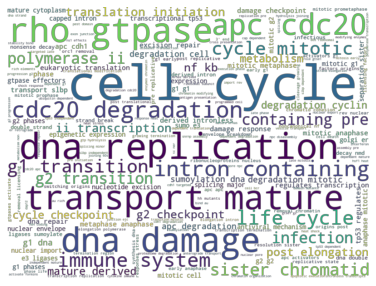

In [11]:
# we can use a word cloud to view what terms are enriched
word_cloud = create_wordcloud(reactome_only.sig)
word_cloud.plot();

In [12]:
word_cloud.data.head(20)

words  counts
181              cell cycle     325
208         dna replication     160
249              rho gtpase     142
243              dna damage     139
179        transport mature     138
586               apc cdc20     132
587       cdc20 degradation     122
175       intron containing     121
353           immune system      98
199              life cycle      97
228           cycle mitotic      95
381           g1 transition      94
355        sister chromatid      86
176          containing pre      80
236           polymerase ii      79
400           g2 transition      79
5                 infection      77
429  translation initiation      77
237        ii transcription      75
261         post elongation      73

In [13]:
def print_numbers(term_name):
    genes = reactome_only.sig.term_to_genes(term_name)
    n_sig = len(genes)
    if n_sig:
        n_sig_ptms = len(exp_data.subset(genes).sig.label_list)
        print("{} : {} : {}".format(term_name, n_sig, n_sig_ptms))
print_numbers('cell cycle')
print_numbers('dna repair')
print_numbers('apoptosis')

cell cycle : 247 : 600
dna repair : 110 : 232
apoptosis : 72 : 138


## Phospho-SILAC enrichment

### Filtering enrichment output

In [14]:
# subset the data to only look at ph-silac data. 
# Later on we will look at label-free, then both.

ph_silac = reactome_only.filter_multi(
    category=['ph_silac_up', 'ph_silac_down'],
)

# arbitrary value that can be easily changed. 
ph_silac.require_n_sig(n_sig=3, inplace=True)

not_useful = [              
    'gene expression', 'translation',
    'immune system',
    'disease', 'diseases of signal transduction',
    'infectious disease', 
    'influenza infection', 'influenza life cycle', 
    'influenza viral rna transcription and replication', 
]
ph_silac = ph_silac.loc[~ph_silac['term_name'].isin(not_useful)]
ph_silac_copy = ph_silac.copy()

ph_silac.remove_redundant(
    threshold=.5, 
    level='dataframe',
    sort_by='combined_score',
    inplace=True
)

Number of rows went from 159 to 29


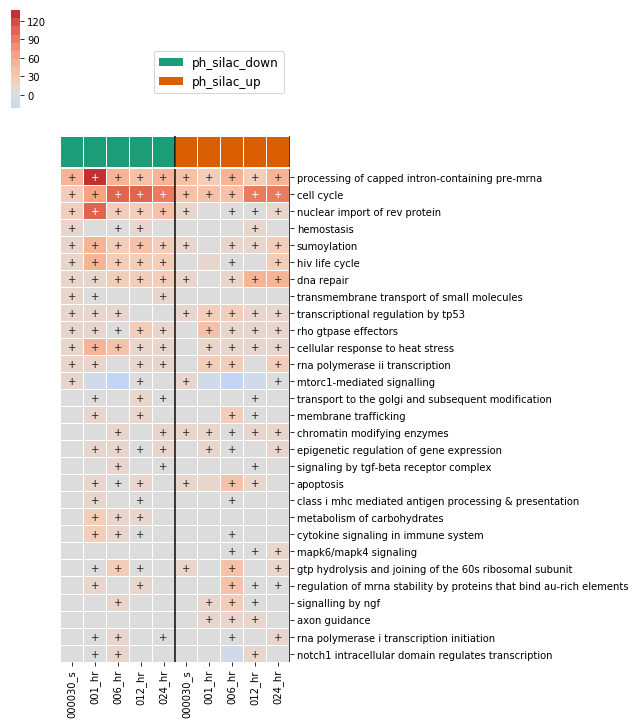

In [15]:
ph_silac.heatmap(
    convert_to_log=False, 
    cluster_by_set=False,
    cluster_row=False,
    values='combined_score',
    columns=['category', 'sample_id'],
    annotate_sig=True, 
    div_colors=True,
    linewidths=.005, 
    figsize=(5,12)
);
plt.savefig("ph_silac_enriched.png", dpi=300, bbox_inches='tight')

Number of rows went from 159 to 36


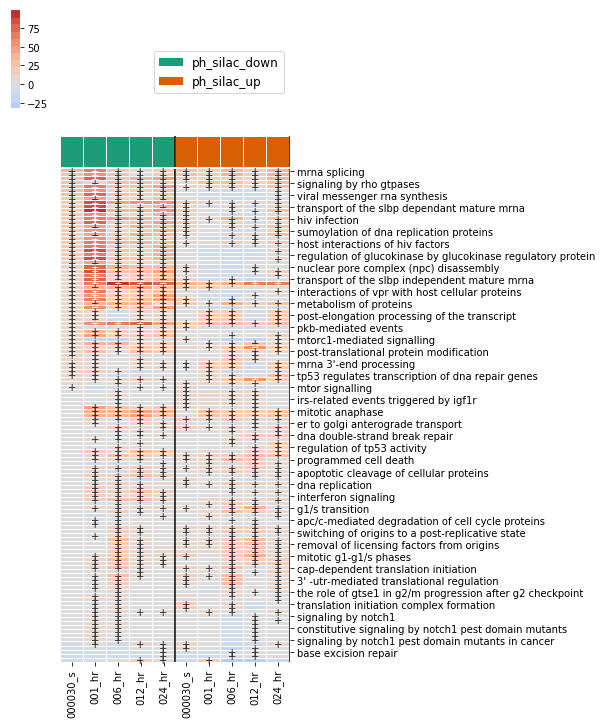

In [16]:
# This figure shows the process of discovering "too general/not useful term". 
# Translation involves various genes that make up individual process
ph_silac_copy.show_terms_below("translation").heatmap(
    convert_to_log=False, 
    cluster_by_set=False,
    cluster_row=False,
    values='combined_score',
    columns=['category', 'sample_id'],
    annotate_sig=True, 
    div_colors=True,
    linewidths=.005, 
    figsize=(5, 12)
);

Number of rows went from 159 to 29


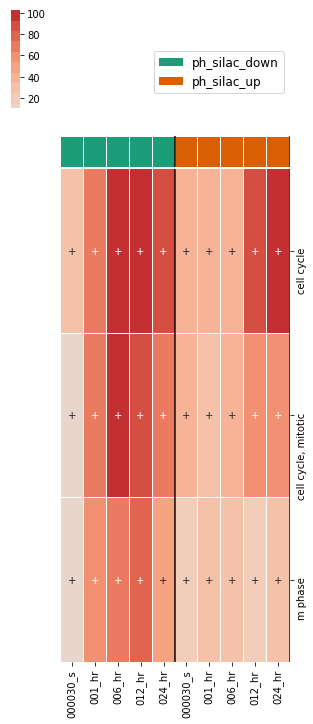

In [17]:
# We can use the same thought process to find more specific terms
ph_silac_copy.show_terms_below("cell cycle", remove_subset=False, threshold=.5).require_n_sig(n_sig=1).heatmap(
    convert_to_log=False, 
    cluster_by_set=False,
    cluster_row=False,
    values='combined_score',
    columns=['category', 'sample_id'],
    annotate_sig=True, 
    div_colors=True,
    linewidths=.005, 
    figsize=(5, 12)
);
plt.savefig("below_cell_cycle.png", bbox_inches='tight', dpi=300)

### Creating an annotated set network.

In [18]:
term_net, mol_net = create_subnetwork( 
    ph_silac, 
    network=network, 
    save_name='ph_silac_ags',
    use_cytoscape=False,
    use_fdr=True, use_threshold=True, min_edges=20
)

Creating ontology network


In [19]:
vis.draw_cyjs(term_net, default_color='white', layout='concentric', spacingFactor=2.8)

### Known mechanisms of bendamustine

Creating ontology network
311
2406


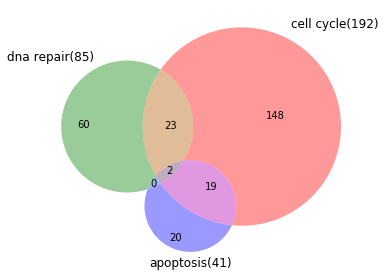

In [20]:
selected_terms = ['dna repair', 'cell cycle', 'apoptosis']

g_sets = [ph_silac.sig.term_to_genes(i) for i in selected_terms]
create_venn3(*g_sets+selected_terms, save_name='venn_canonical');

subset = reactome_only.sig.loc[reactome_only.sig.term_name.isin(selected_terms)].copy()
term_net, mol_net = create_subnetwork( 
    subset, 
    network=network, 
    save_name='apop_dna_cell_cycle',
    use_cytoscape=False,
    use_fdr=True, 
    use_threshold=True,
    min_edges=10
)
print(len(mol_net.nodes))
print(len(mol_net.edges))

In [21]:
nx.set_node_attributes(term_net, 'white', 'color')
vis.draw_cyjs(term_net, layout='concentric', spacingFactor=2.8)

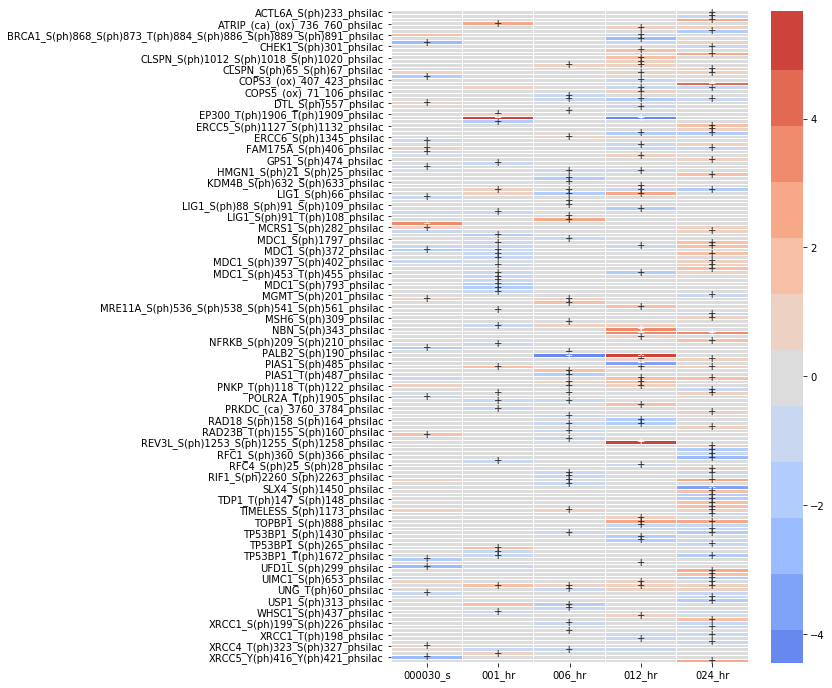

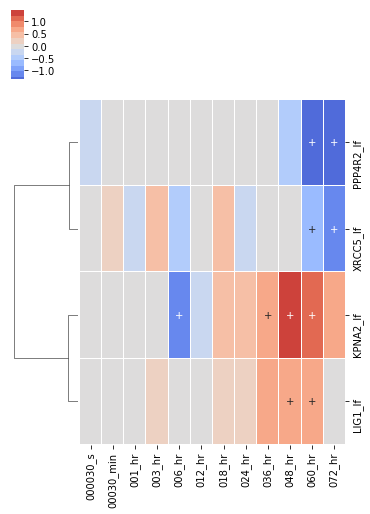

In [22]:
ph_silac_dna_repair_genes = ph_silac.term_to_genes('dna repair')
exp_data.ph_silac.heatmap(
    ph_silac_dna_repair_genes,
    subset_index='identifier',
    index='label',
    cluster_row=False,
    rank_index=True,
    min_sig=1,
    num_colors=13,
    linewidths=0.01
);
plt.savefig("dna_repair_ph_silac.png", dpi=300, bbox_inches='tight')
exp_data.label_free.heatmap(
    ph_silac_dna_repair_genes,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=2,
    num_colors=13,
    linewidths=0.01,
    figsize=(6, 8)
);
plt.savefig("dna_repair_lf.png", dpi=300, bbox_inches='tight')

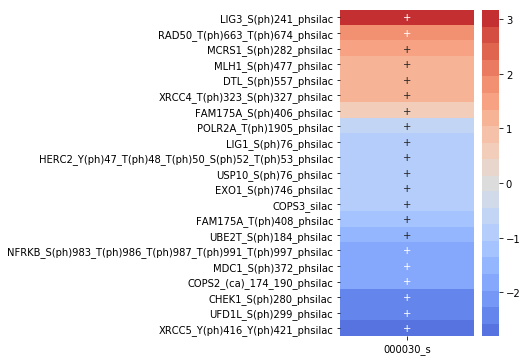

In [23]:
exp_data.species.subset(ph_silac_dna_repair_genes, sample_ids=['000030_s']).sig.heatmap(figsize=(3,6), index='label');

In [24]:
dna_repair_subnet = net_sub.expand_neighbors(
    nodes=ph_silac.term_to_genes('dna repair'), 
    upstream=True, downstream=True,
    add_interconnecting_edges=True,
    max_dist=2,
    include_only=ph_silac.term_to_genes('dna repair')
)
dna_repair_subnet = utils.delete_disconnected_network(dna_repair_subnet)

Node not in graph
Node not in graph
Node not in graph


In [25]:
vis.draw_cyjs(dna_repair_subnet, layout='concentric', spacingFactor=1.)

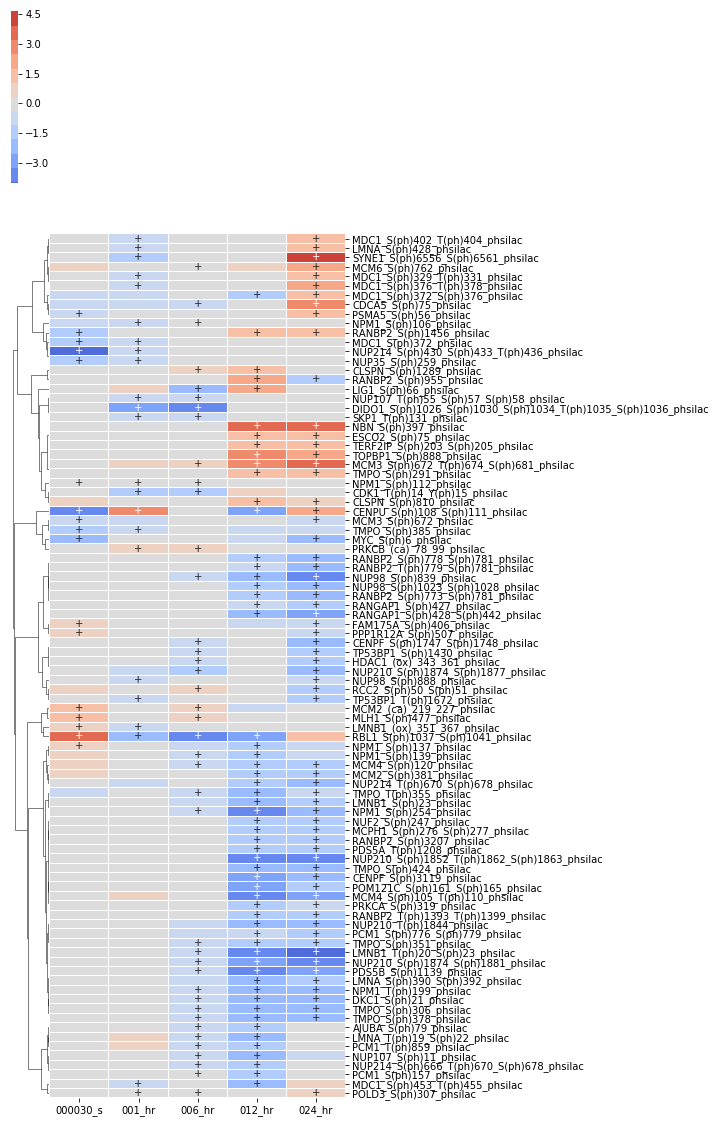

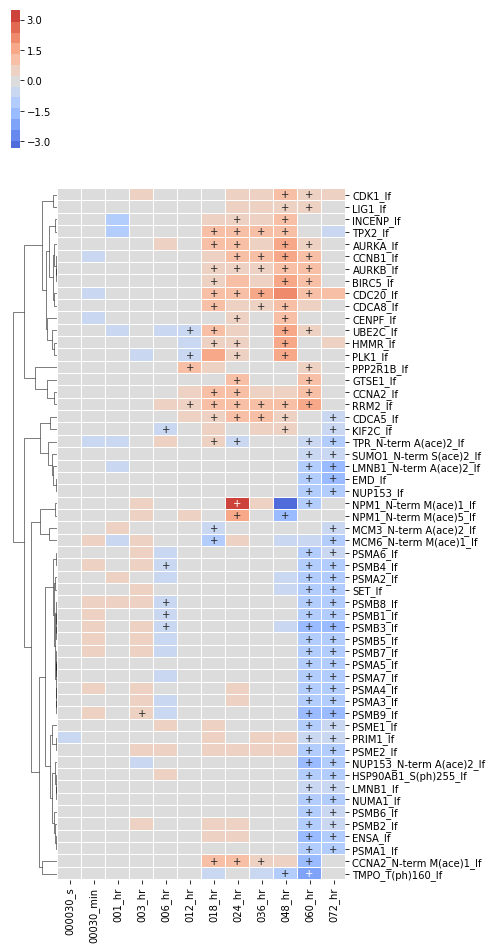

In [26]:
exp_data.ph_silac.heatmap(
    reactome_only.term_to_genes('cell cycle'),
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=2,
    num_colors=13,
    linewidths=0.01,
    figsize=(6, 20),
    y_tick_labels=True
);
plt.savefig("cell_cycle_ph_silac.png", dpi=300, bbox_inches='tight')
exp_data.label_free.heatmap(
    reactome_only.term_to_genes('cell cycle'),
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=2,
    num_colors=13,
    linewidths=0.01,
    figsize=(6,16)
);
plt.savefig("cell_cycle_label_free.png", dpi=300, bbox_inches='tight')

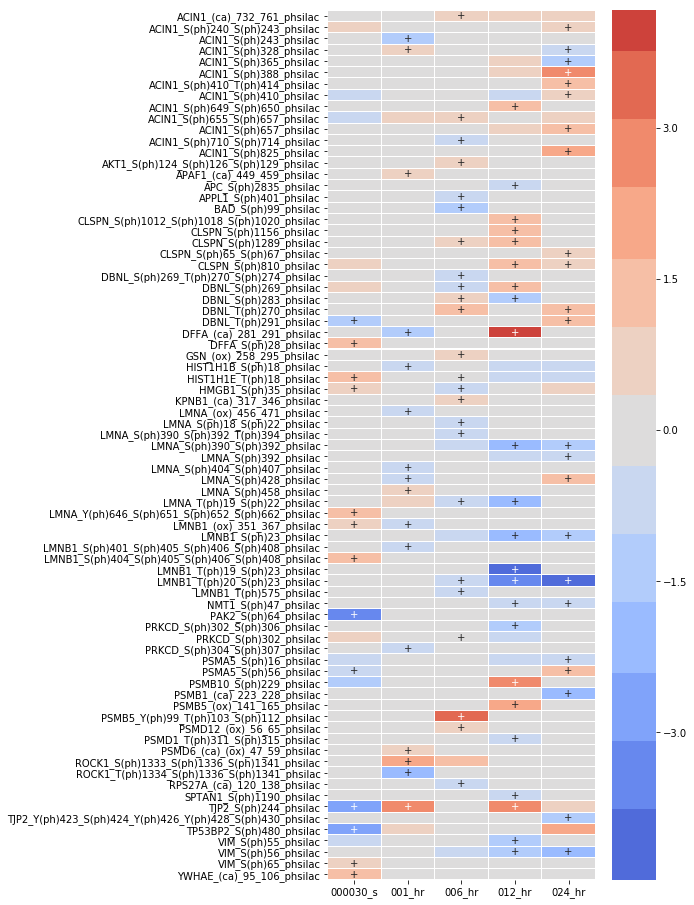

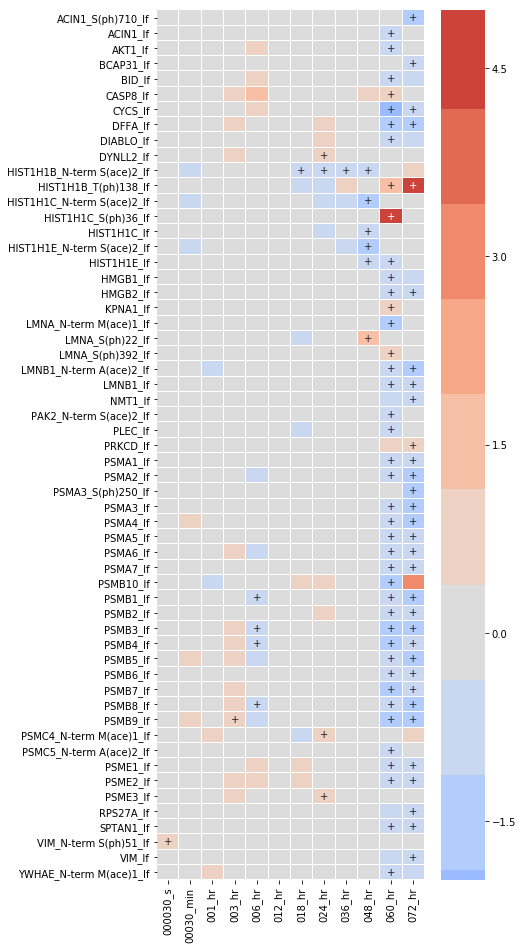

In [27]:
exp_data.ph_silac.heatmap(
    reactome_only.sig.term_to_genes('apoptosis'),
    subset_index='identifier',
    index='label',
    cluster_row=False,
    rank_index=True,
    min_sig=1,
    num_colors=13,
    linewidths=0.01,
    figsize=(6,16)
);
plt.savefig("apoptosis_ph_silac.png", dpi=300, bbox_inches='tight')

exp_data.label_free.heatmap(
    reactome_only.sig.term_to_genes('apoptosis'),
    subset_index='identifier',
    index='label',
    cluster_row=False,
    rank_index=True,
    min_sig=1,
    num_colors=13,
    linewidths=0.01,
    figsize=(6,16)
);
plt.savefig("apoptosis_lf.png", dpi=300, bbox_inches='tight')

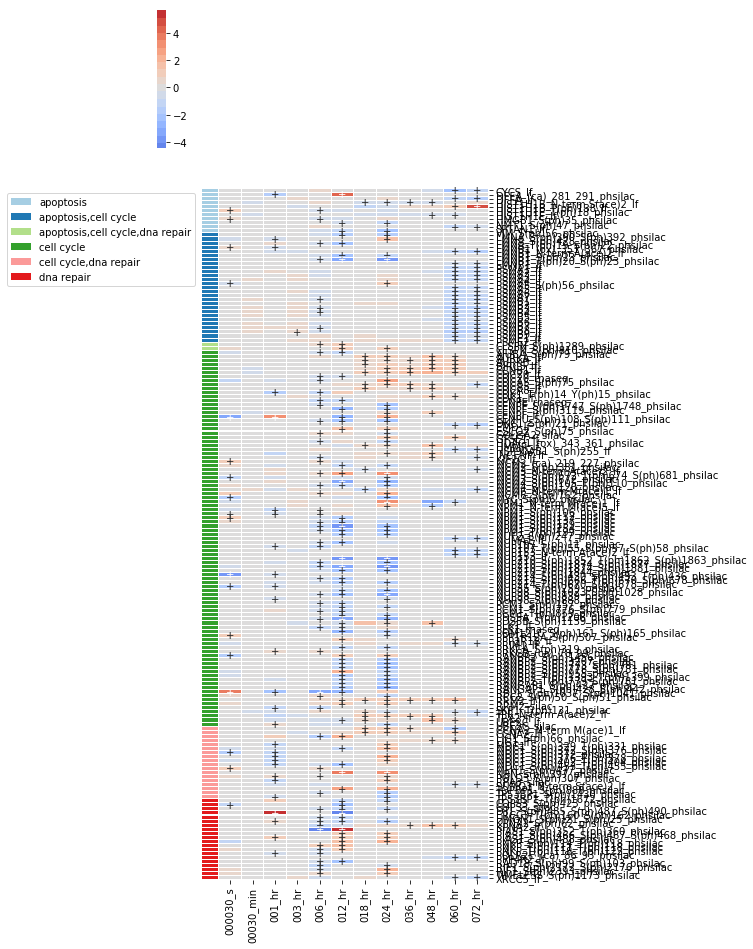

In [28]:
genes_in_labels = utils.create_dict_from_node_attributes(mol_net, 'termName')
heatmap_by_terms(
    exp_data.species,
    convert_to_log=True,
    index='label',
    term_labels=list(genes_in_labels.keys()),
    term_sets=list(genes_in_labels.values()),
    div_colors=True, 
    linewidths=0.01,
    min_sig=2,
    annotate_sig=True, 
    cluster_col=False,
    cluster_row=False,
    y_tick_labels=True,
    figsize=(8, 16)
);
plt.savefig("agn_all_species.png", dpi=300, bbox_inches='tight')

### Lets look at only up-regulated ph-silac

Number of terms before filtering base on minimum time points : 560      
Number of terms after filtering base on minimum time points : 83      
Number of rows went from 83 to 30
Number of rows went from 30 to 17
Number of genes before : 570
Number of genes after : 550


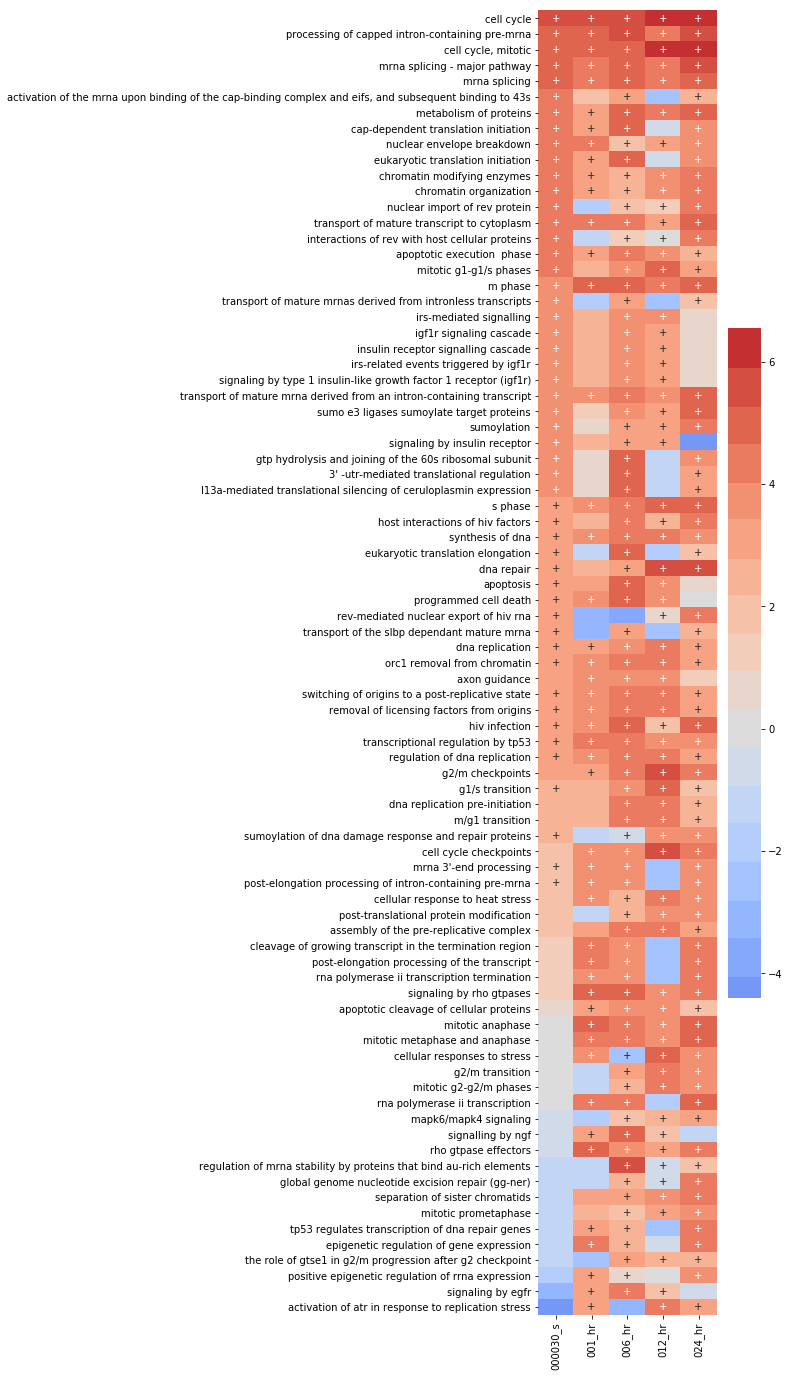

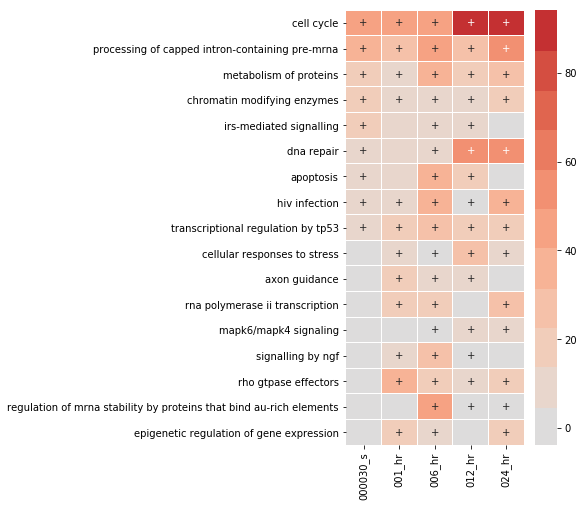

In [29]:
ph_silac_up = reactome_only.filter_multi(category=['ph_silac_up'])

not_useful = [              
    'gene expression', 'translation',
    'immune system',
    'disease', 'diseases of signal transduction',
    'infectious disease', 
    'influenza infection', 'influenza life cycle', 
    'influenza viral rna transcription and replication', 
]

ph_silac_up = ph_silac_up.loc[~ph_silac_up['term_name'].isin(not_useful)]

print("Number of terms before filtering base on minimum time points : {}\
      ".format(len(ph_silac_up.term_name.unique())))

ph_silac_up.require_n_sig(
    index='term_name', 
    columns='sample_id', 
    n_sig=3,
    inplace=True
)
ph_silac_up_copy = ph_silac_up.copy()
print("Number of terms after filtering base on minimum time points : {}\
      ".format(len(ph_silac_up.term_name.unique())))

fig = ph_silac_up_copy.heatmap(figsize=(4, 24));
fig.savefig('ph_silac.png', dpi=300, bbox_inches='tight')

ph_silac_up.remove_redundant(
    threshold=.7, 
    level='sample',
    inplace=True, 
    sort_by='combined_score'
)

ph_silac_up.remove_redundant(
    threshold=.7, 
    level='dataframe',
    inplace=True, 
    sort_by='combined_score'
)
print("Number of genes before : {}".format(len(ph_silac_up_copy.all_genes_from_df())))
print("Number of genes after : {}".format(len(ph_silac_up.all_genes_from_df())))
fig = ph_silac_up.heatmap(
    convert_to_log=False, 
    cluster_by_set=False,
    cluster_row=False,
    values='combined_score',
    annotate_sig=True, 
    div_colors=True,
    linewidths=.005, 
    figsize=(4,8)
);
fig.savefig('ph_silac_slimmed.png', dpi=300, bbox_inches='tight')

In [30]:
term_net, mol_net = create_subnetwork( 
    ph_silac_up, 
    network=network, 
    save_name='ph_silac_ASN',
    use_cytoscape=False,
    use_fdr=True, use_threshold=True, min_edges=25
)
for i in ph_silac_up.term_name.unique():
    if i not in term_net.nodes:
        print(i)

Creating ontology network


In [31]:
nx.set_node_attributes(term_net, 'white', 'color')
vis.draw_cyjs(term_net, layout='cose-bilkent', spacingFactor=1.4)

In [32]:
sorted(ph_silac_up.term_name.unique())

['apoptosis',
 'axon guidance',
 'cell cycle',
 'cellular responses to stress',
 'chromatin modifying enzymes',
 'dna repair',
 'epigenetic regulation of gene expression',
 'hiv infection',
 'irs-mediated signalling',
 'mapk6/mapk4 signaling',
 'metabolism of proteins',
 'processing of capped intron-containing pre-mrna',
 'regulation of mrna stability by proteins that bind au-rich elements',
 'rho gtpase effectors',
 'rna polymerase ii transcription',
 'signalling by ngf',
 'transcriptional regulation by tp53']

### Back to known mechanisms of bendamustine

In [33]:
hits = [
    'dna repair',
    'cell cycle',
    'apoptosis', 
]

Number of rows went from 83 to 17


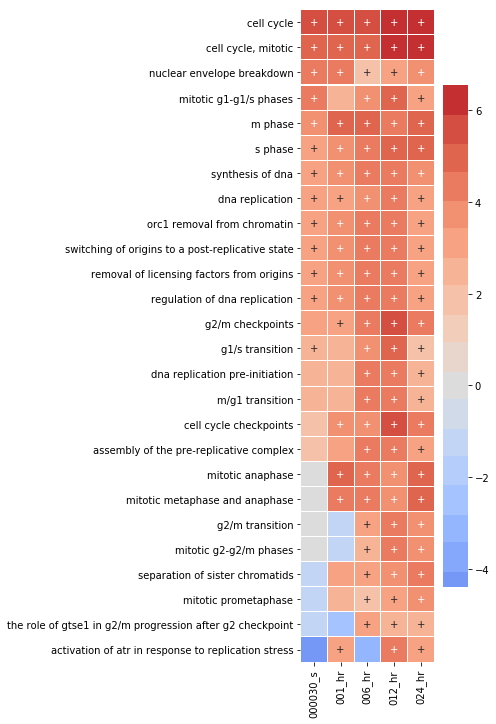

In [34]:
ph_silac_up_copy.show_terms_below(
    'cell cycle', 
    threshold=.7, 
    remove_subset=True
).heatmap(figsize=(3, 12), cluster_by_set=False, 
          linewidths=0.01,);
plt.savefig("below_cc_ph_silac.png", dpi=300, bbox_inches='tight')

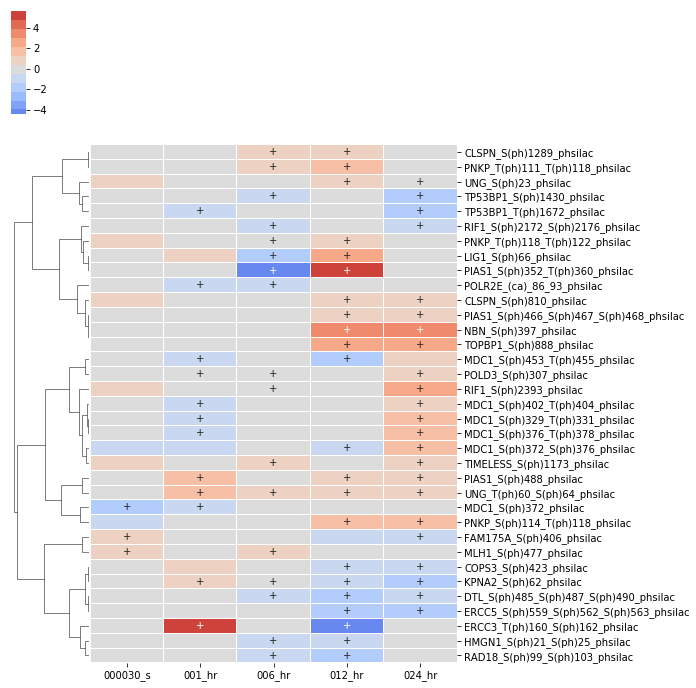

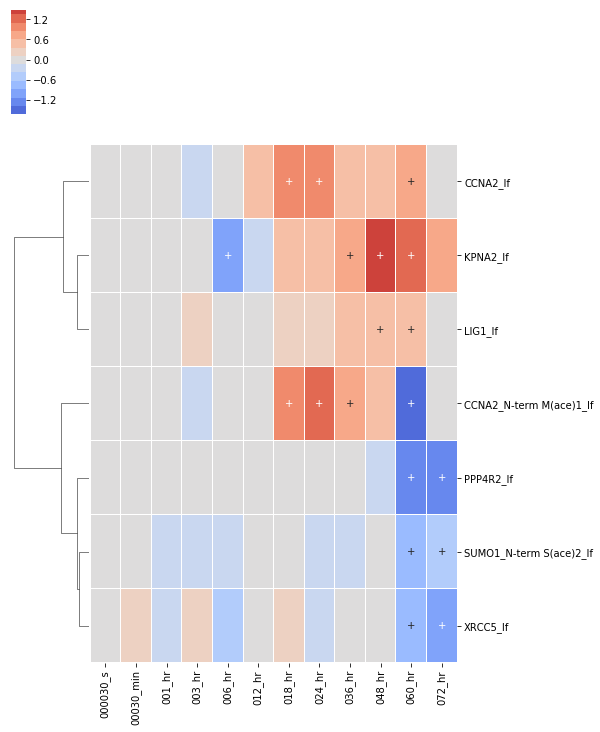

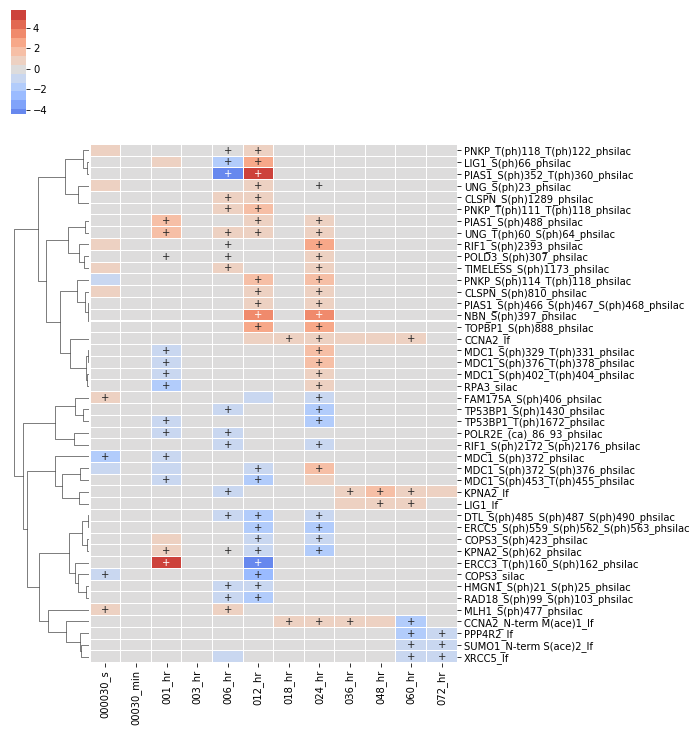

In [35]:
dna_repair_genes = reactome_only.sig.term_to_genes('dna repair')
exp_data.ph_silac.heatmap(
    dna_repair_genes,
    convert_to_log=True,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=2,
    num_colors=13,
    linewidths=0.01
);
plt.savefig("dna_repair.png", dpi=300, bbox_inches='tight')

exp_data.label_free.heatmap(
    dna_repair_genes,
    convert_to_log=True,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=2,
    num_colors=13,
    linewidths=0.01
);
plt.savefig("dna_repair_lf.png", dpi=300, bbox_inches='tight')

exp_data.species.heatmap(
    dna_repair_genes,
    convert_to_log=True,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=2,
    num_colors=13,
    linewidths=0.01
);
plt.savefig("dna_repair_all.png", dpi=300, bbox_inches='tight')

In [36]:
dna_repair_subnet = net_sub.expand_neighbors(
    nodes=reactome_only.sig.term_to_genes('dna repair'), 
    upstream=True, downstream=True,
    add_interconnecting_edges=True,
    max_dist=2,
    include_only=reactome_only.sig.term_to_genes('dna repair')
)
dna_repair_subnet = utils.delete_disconnected_network(dna_repair_subnet)
print(len(dna_repair_subnet.nodes))
print(len(dna_repair_subnet.edges))

Node not in graph
Node not in graph
Node not in graph
97
397


In [37]:
vis.draw_cyjs(dna_repair_subnet, layout='cose-bilkent', spacingFactor=2.)

Number of rows went from 83 to 17


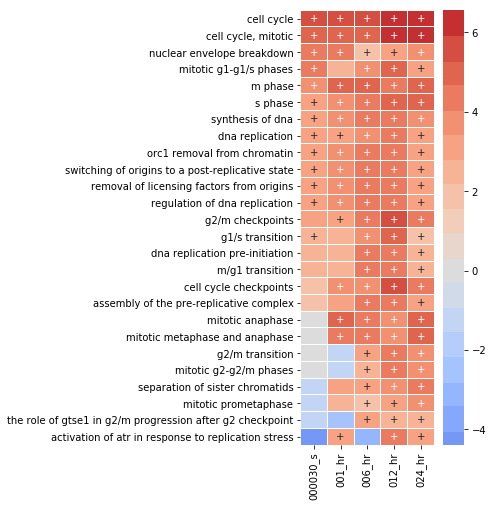

In [38]:
ph_silac_up_copy.show_terms_below(
    'cell cycle', 
    threshold=.7, 
    remove_subset=True
).heatmap(figsize=(3, 8), linewidths=0.01,);

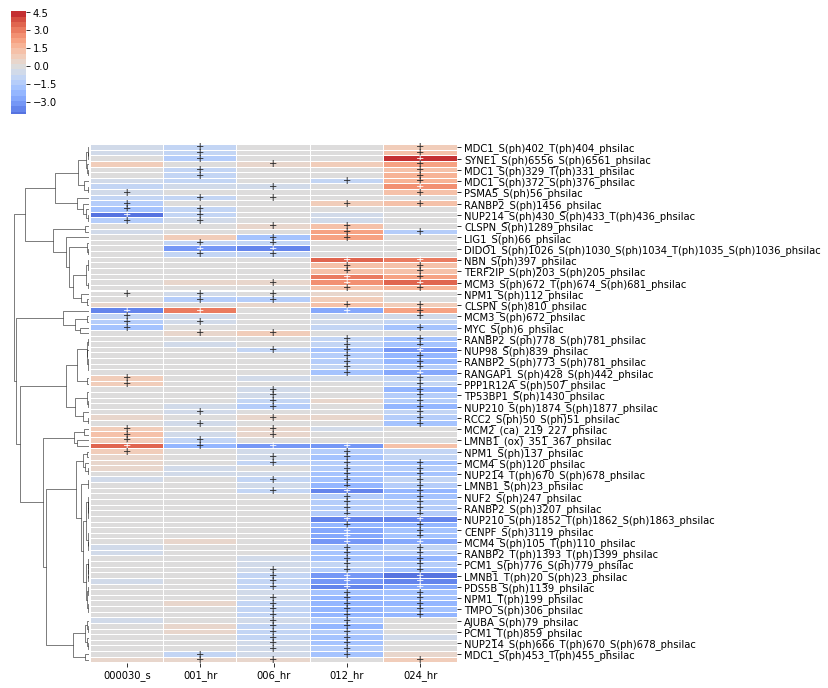

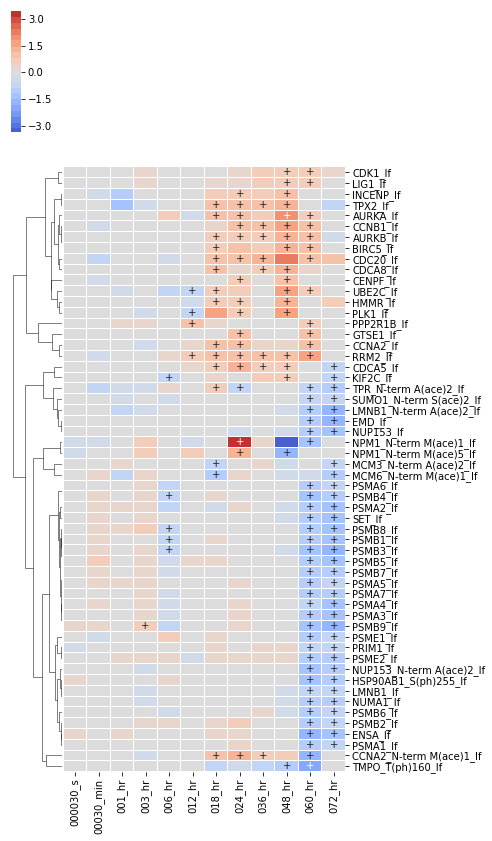

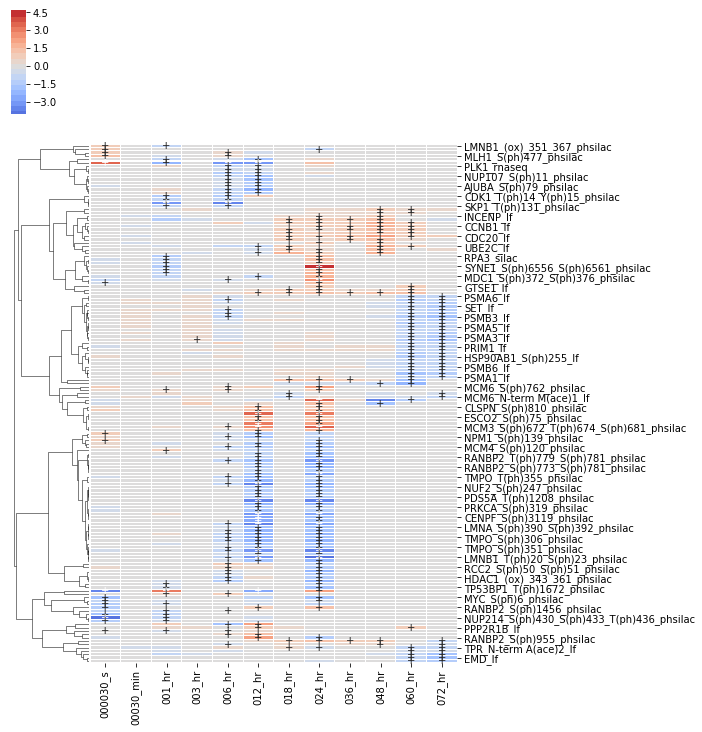

In [39]:
cell_cycle_genes = reactome_only.sig.term_to_genes('cell cycle')
exp_data.ph_silac.heatmap(
    cell_cycle_genes,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=2,
    linewidths=0.01
);
plt.savefig("cell_cycle_ph_silac.png", dpi=300, bbox_inches='tight')

exp_data.label_free.heatmap(
    cell_cycle_genes,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=2,
    linewidths=0.01,
    figsize=(6, 14)
);
plt.savefig("cell_cycle_lf.png", dpi=300, bbox_inches='tight')

exp_data.species.heatmap(
    cell_cycle_genes,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=2,
    linewidths=0.01
);
plt.savefig("cell_cycle_all.png", dpi=300, bbox_inches='tight')

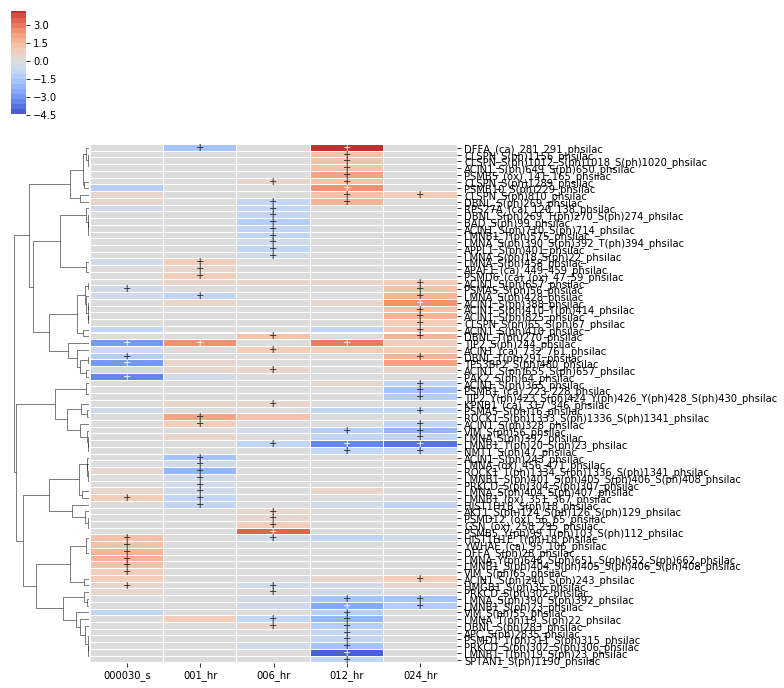

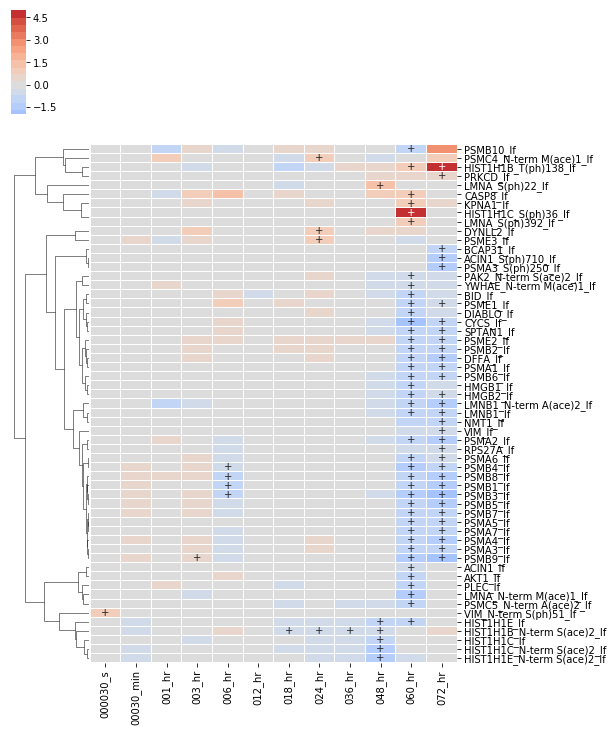

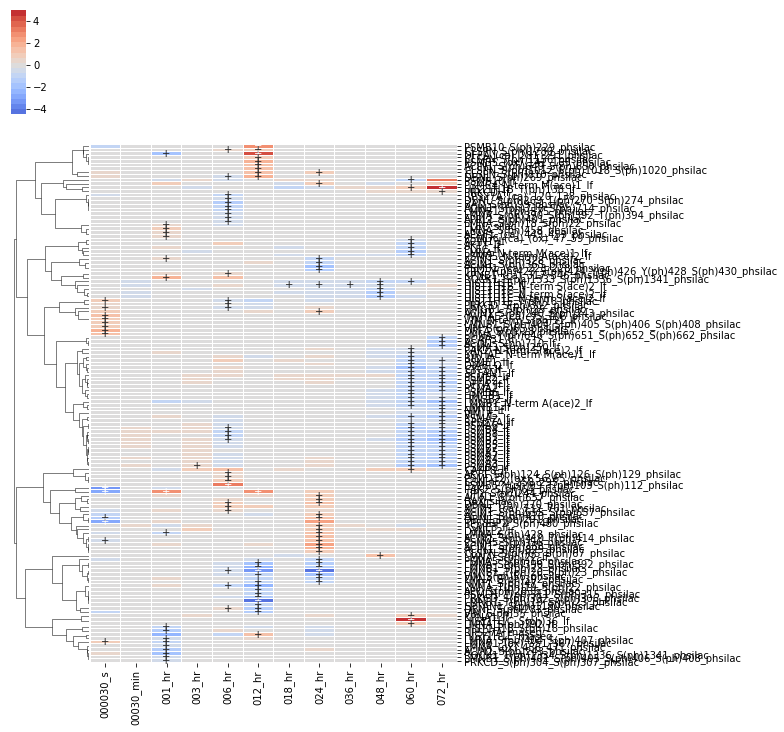

In [40]:
apoptosis_genes = reactome_only.sig.term_to_genes('apoptosis')
exp_data.ph_silac.heatmap(
    apoptosis_genes,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=1,
    linewidths=0.01,
    y_tick_labels=True
);
plt.savefig("apoptosis_ph_silac.png", dpi=300, bbox_inches='tight')

exp_data.label_free.heatmap(
    apoptosis_genes,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=1,
    linewidths=0.01,
    y_tick_labels=True
);
plt.savefig("apoptosis_lf.png", dpi=300, bbox_inches='tight')

exp_data.species.heatmap(
    apoptosis_genes,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=1,
    linewidths=0.01,
    y_tick_labels=True
);
plt.savefig("apoptosis_all.png", dpi=300, bbox_inches='tight')

In [41]:
print("DNA repair")
for i in exp_data.exp_methods:
    print("\t", i, len(exp_data[i].subset(dna_repair_genes).sig.id_list), 
          len(exp_data[i].subset(dna_repair_genes).sig.label_list))
print("Cell cycle")
for i in exp_data.exp_methods:
    print("\t", i, len(exp_data[i].subset(cell_cycle_genes).sig.id_list), 
          len(exp_data[i].subset(cell_cycle_genes).sig.label_list))
print("Apoptosis")
for i in exp_data.exp_methods:
    print("\t", i, len(exp_data[i].subset(apoptosis_genes).sig.id_list), 
          len(exp_data[i].subset(apoptosis_genes).sig.label_list))

DNA repair
	 silac 7 7
	 ph_silac 80 173
	 HILIC 0 0
	 C18 0 0
	 label_free 43 47
	 rna_seq 5 5
Cell cycle
	 silac 10 10
	 ph_silac 153 444
	 HILIC 0 0
	 C18 0 0
	 label_free 111 129
	 rna_seq 17 17
Apoptosis
	 silac 2 2
	 ph_silac 33 77
	 HILIC 0 0
	 C18 0 0
	 label_free 47 57
	 rna_seq 2 2


Creating ontology network
311
2406


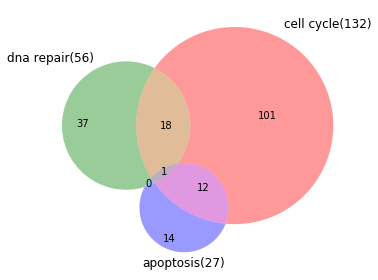

In [42]:
g_sets = [ph_silac_up.sig.term_to_genes(i) for i in hits]
create_venn3(*g_sets+hits, save_name='venn_canonical');

subset = reactome_only.sig.loc[reactome_only.sig.term_name.isin(hits)].copy()
term_net, mol_net = create_subnetwork( 
    subset, 
    network=network, 
    save_name='apop_dna_cell_cycle',
    use_cytoscape=False,
    use_fdr=True, 
    use_threshold=True,
    min_edges=10
)
print(len(mol_net.nodes))
print(len(mol_net.edges))

In [43]:
nx.set_node_attributes(term_net, 'white', 'color',)
vis.draw_cyjs(term_net, layout='concentric', add_parent=True, spacingFactor=2.)

In [44]:
counter = dict()
for i,j in mol_net.nodes(data='termName'):
    if j not in counter:
        counter[j] = 1
    else:
        counter[j]+=1
for i,j in counter.items():
    print(i,j)

dna repair 65
apoptosis,cell cycle,dna repair 2
apoptosis,cell cycle 37
apoptosis 28
cell cycle,dna repair 33
cell cycle 146


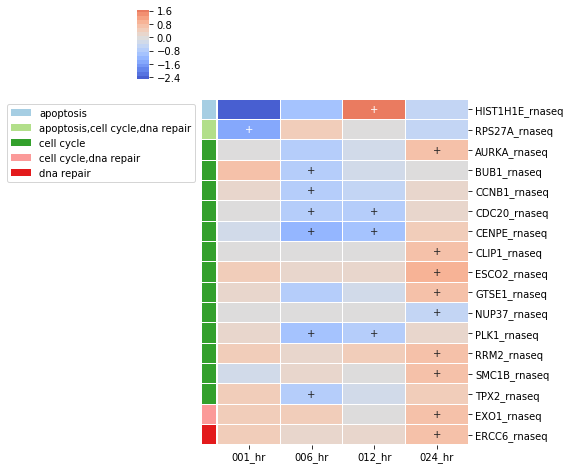

In [45]:
genes_in_labels = utils.create_dict_from_node_attributes(mol_net, 'termName')
heatmap_by_terms(
    exp_data.rna,
    convert_to_log=True,
    index='label',
    term_labels=list(genes_in_labels.keys()),
    term_sets=list(genes_in_labels.values()),
    div_colors=True, 
    linewidths=0.01,
    min_sig=1,
    annotate_sig=True, 
    cluster_col=False,
    cluster_row=False,
    y_tick_labels=True,
    figsize=(8, 8)
);
plt.savefig("agn_all_species_rna.png", dpi=300, bbox_inches='tight')

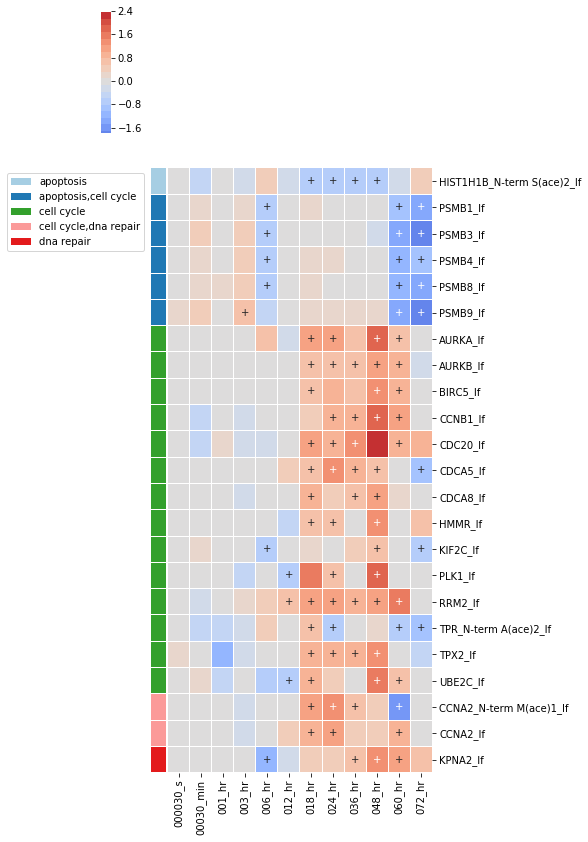

In [46]:
heatmap_by_terms(
    exp_data.label_free,
    convert_to_log=True,
    index='label',
    term_labels=list(genes_in_labels.keys()),
    term_sets=list(genes_in_labels.values()),
    div_colors=True, 
    linewidths=0.01,
    min_sig=3,
    annotate_sig=True, 
    cluster_col=False,
    cluster_row=False,
    y_tick_labels=True,
    figsize=(8, 14)
);
plt.savefig("agn_all_species_lf.png", dpi=300, bbox_inches='tight')

#### Cross referencing terms across other data types

Creating ontology network
329
2557
303
2531


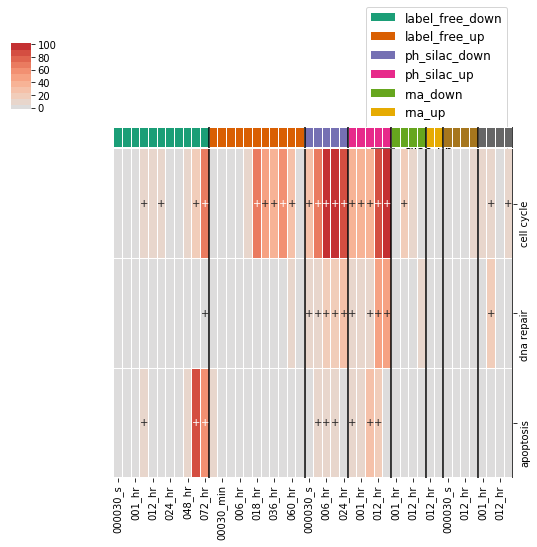

In [47]:
subset = reactome_only.loc[reactome_only.term_name.isin(hits)].copy()

subset.filter_multi(
    category=['ph_silac_down', 'ph_silac_up', 
              'label_free_down', 'label_free_up',
              'silac_up', 'silac_down', 
              'rna_up', 'rna_down'],
    inplace=True,
)

fig = subset.heatmap(
    convert_to_log=False,
    cluster_by_set=False,
    annotate_sig=True, 
    columns=['category', 'sample_id'],
    div_colors=True,
    linewidths=.005, 
    figsize=(9, 8)
);

term_net, mol_net = create_subnetwork( 
    subset, 
    network, 
    save_name='all_selected',
    use_cytoscape=False,
    use_fdr=True, use_threshold=True,
    remove_isolated=True
)


print(mol_net.number_of_nodes())
print(mol_net.number_of_edges())
mol_net = utils.trim_sink_source_nodes(mol_net)
print(mol_net.number_of_nodes())
print(mol_net.number_of_edges())
nx.write_gml(mol_net, 'subgraph_dna_damage_apoptosis_cell_cycle.gml')

### Exploring terms outside canonical

Number of rows went from 83 to 17


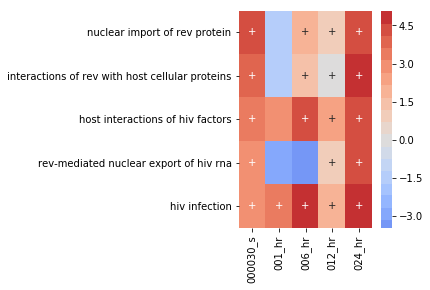

In [48]:
ph_silac_up_copy.show_terms_below('hiv infection', threshold=.7).heatmap(figsize=(3,4));

Creating ontology network


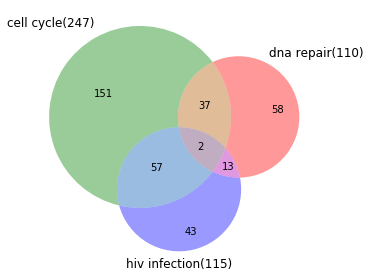

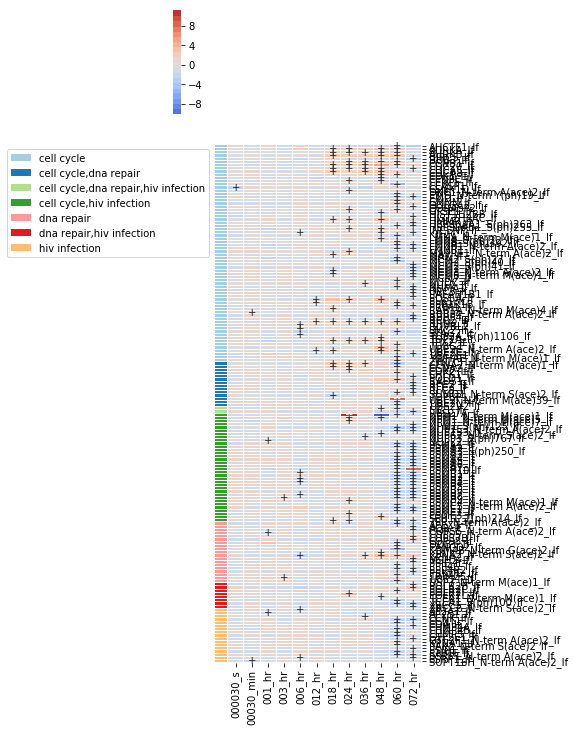

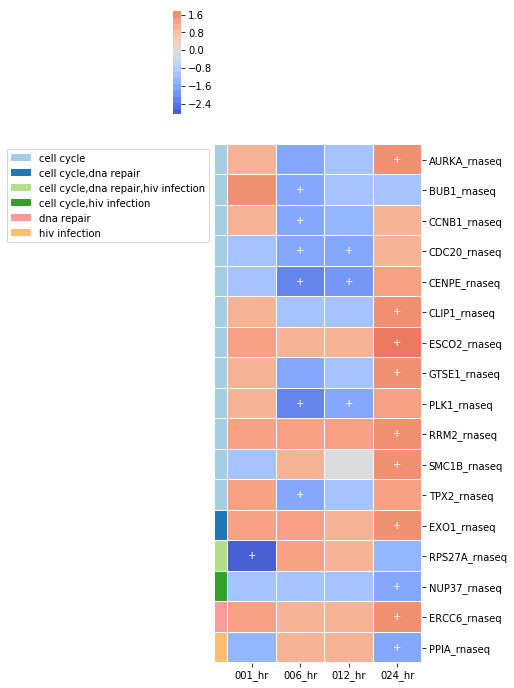

In [49]:
hits = [ 
    'cell cycle',
    'dna repair',
    'hiv infection'
]
subset = reactome_only.sig.loc[reactome_only.sig.term_name.isin(hits)].copy()
term_net, mol_net = create_subnetwork( 
    subset, 
    network=network, 
    save_name='hiv',
    use_cytoscape=False,
    use_fdr=True, use_threshold=True, min_edges=10
)

g_sets = [reactome_only.sig.term_to_genes(i) for i in hits]
create_venn3(*g_sets+hits);
plt.savefig('venn_hiv.png', dpi=450) 

genes_in_labels = utils.create_dict_from_node_attributes(mol_net, 'termName')
    
heatmap_by_terms(
    exp_data.label_free,
    convert_to_log=False,
    index='label',
    term_labels=list(genes_in_labels.keys()),
    term_sets=list(genes_in_labels.values()),
    div_colors=True, 
    linewidths=0.01,
    min_sig=1,
    annotate_sig=True, 
    cluster_col=False,
    figsize=(6,12),
    y_tick_labels=True
);
heatmap_by_terms(
    exp_data.rna,
    convert_to_log=False,
    index='label',
    term_labels=list(genes_in_labels.keys()),
    term_sets=list(genes_in_labels.values()),
    div_colors=True, 
    linewidths=0.01,
    min_sig=1,
    annotate_sig=True, 
    cluster_col=False,
    figsize=(6,12),
    y_tick_labels=True
);

In [50]:
vis.draw_cyjs(term_net)

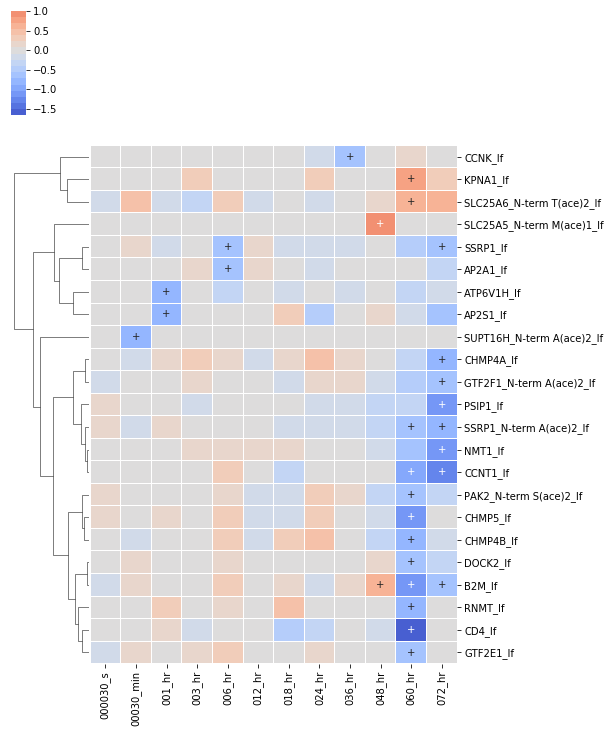

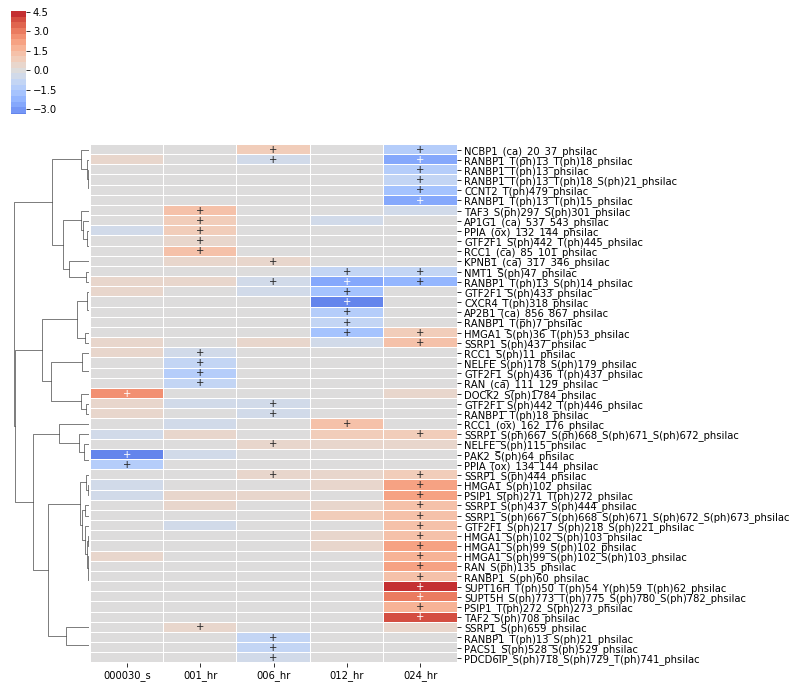

In [51]:
hiv_only= g_sets[-1]
hiv_only.difference_update(g_sets[0]) # remove dna repair genes
hiv_only.difference_update(g_sets[1]) # removes cell cycle genes

exp_data.label_free.heatmap(
    hiv_only, 
    cluster_row=True, 
    subset_index='identifier', 
    index='label',
    min_sig=1,
    linewidths=0.01
);
exp_data.ph_silac.heatmap(
    hiv_only,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    rank_index=True,
    min_sig=1,
    linewidths=0.01
);
plt.savefig("HIV_life_cycle.png", dpi=300, bbox_inches='tight')

### Exploring a subset of terms based on a keyword

478


term_name  rank  \
3504789         dna damage induced protein phosphorylation    12   
3504932  intrinsic apoptotic signaling pathway in respo...   155   
3504975  histone h4 acetylation involved in response to...   198   
3504976           cellular response to dna damage stimulus   199   
3504977  histone h3-k56 acetylation in response to dna ...   200   
3504979  regulation of transcription from rna polymeras...   202   
3504989      signal transduction in response to dna damage   212   
3505010                              dna damage checkpoint   233   
3505029     telomere maintenance in response to dna damage   252   
3505202  dna damage response, signal transduction by p5...   425   
3505281  negative regulation of mitotic dna damage chec...   504   
3505631  regulation of telomere maintenance in response...   854   
3511095                                damaged dna binding    74   
3516776  sumoylation of dna damage response and repair ...    36   
3516900  dna damage/telomere stress induced senescence_...   160   

         combined_score  adj_p_value  n_genes sample_id       category  
3504789           73.18     5.42e-05       36  000030_s  ph_silac_both  
3504932           29.22     2.92e-03       18  000030_s  ph_silac_both  
3504975           25.87     5.85e-03       17  000030_s  ph_silac_both  
3504976           25.87     4.08e-03       16  000030_s  ph_silac_both  
3504977           25.85     4.08e-03       16  000030_s  ph_silac_both  
3504979           25.76     4.26e-03       16  000030_s  ph_silac_both  
3504989           24.76     5.45e-03       16  000030_s  ph_silac_both  
3505010           23.40     8.45e-03       16  000030_s  ph_silac_both  
3505029           21.49     1.27e-02       16  000030_s  ph_silac_both  
3505202           12.66     3.12e-02        9  000030_s  ph_silac_both  
3505281           11.45     2.22e-02        6  000030_s  ph_silac_both  
3505631            0.10     4.32e-02        4  000030_s  ph_silac_both  
3511095           17.49     9.51e-03       29  000030_s  ph_silac_both  
3516776           21.40     6.71e-05       12  000030_s  ph_silac_both  
3516900            0.86     4.80e-02        6  000030_s  ph_silac_both

Number of rows went from 34 to 23


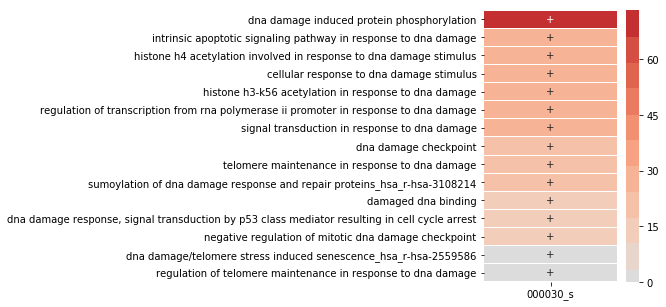

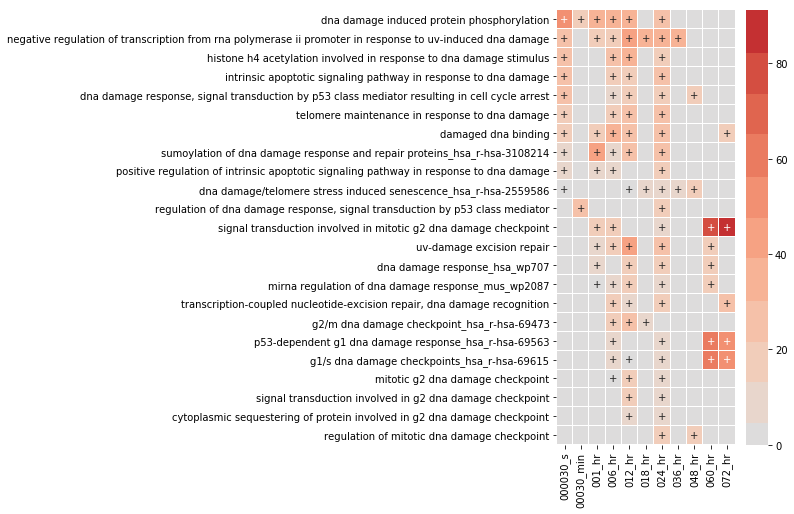

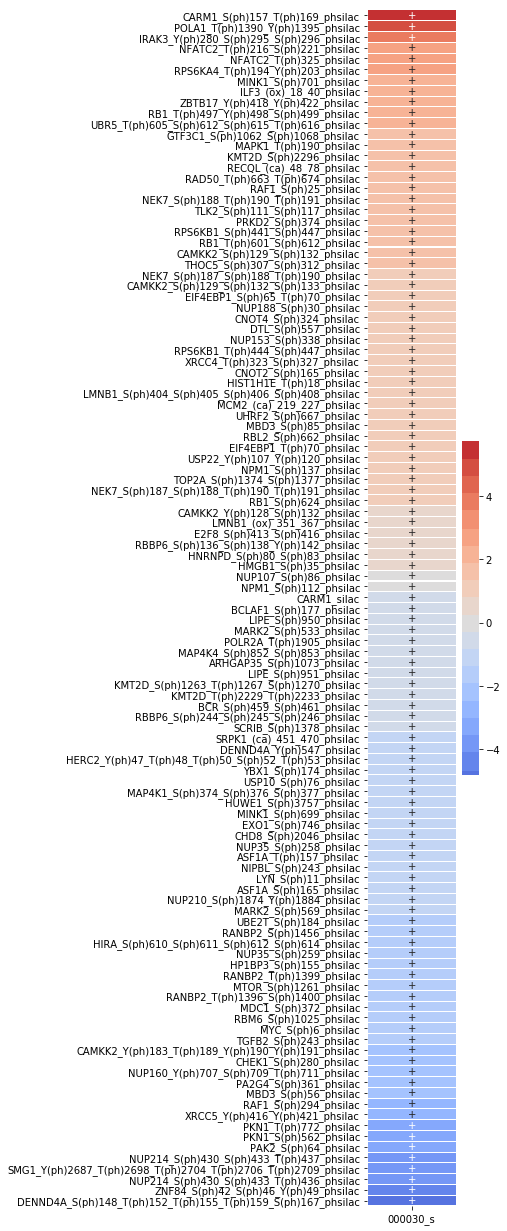

In [52]:
# Filter by terms
damage_terms = enrichment_array.sig.filter_based_on_words(['damage'])
print(len(damage_terms.all_genes_from_df()))
damage_terms.head(10)
damage_terms_all = damage_terms.filter_multi(category='ph_silac_both')
first_damage = damage_terms_all.filter_multi(sample_id='000030_s')
display(first_damage[cols].head(20))

fig = first_damage.heatmap(
    convert_to_log=False,
    cluster_by_set=False,
    annotate_sig=True, 
    div_colors=True,
    linewidths=.01, 
    num_colors=21,
    figsize=(3,5)
);
fig.savefig('dna_damage_terms_30s.png', dpi=300, bbox_inches='tight')

damage_terms.require_n_sig(inplace=True, columns='sample_id', n_sig=2)
damage_terms.remove_redundant(inplace=True, threshold=.5, level='sample')
fig = damage_terms.heatmap(
    convert_to_log=False,
    cluster_by_set=False,
    annotate_sig=True, 
    div_colors=True,
    linewidths=.01, 
    num_colors=21,
    figsize=(4,8)
);
fig.savefig('dna_damage_terms_all.png', bbox_inches='tight')

dna_gene_df = exp_data.subset(first_damage.all_genes_from_df())
dna_gene_df = dna_gene_df.loc[dna_gene_df.sample_id.isin(['000030_s'])]

dna_gene_df.sig.heatmap(
    index='label',
    rank_index=False,
    convert_to_log=True,
    annotate_sig=True, 
    div_colors=True,
    linewidths=.01, 
    num_colors=21,
    figsize=(2,22)
);

### Exploring species of interest

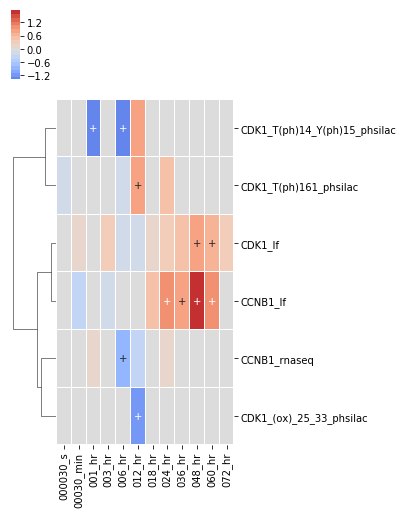

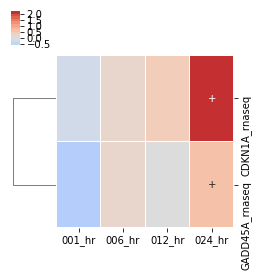

In [53]:
g2_m = ['CDK1', 'CCNB1']
cdk1_inhibitors = ['GADD45A', 'GADD45B', 'GADD45G', 'CDKN1A']

exp_data.species.heatmap(
    g2_m,
    index='label',
    subset_index='identifier',
    figsize=(4,8),
    linewidths=0.01,
    cluster_row=True, 
    min_sig=1
);

exp_data.species.heatmap(
    cdk1_inhibitors,
    index='label',
    subset_index='identifier',
    figsize=(4, 4),
    linewidths=0.01,
    cluster_row=True,
    min_sig=1
);

Removing from list
25
47


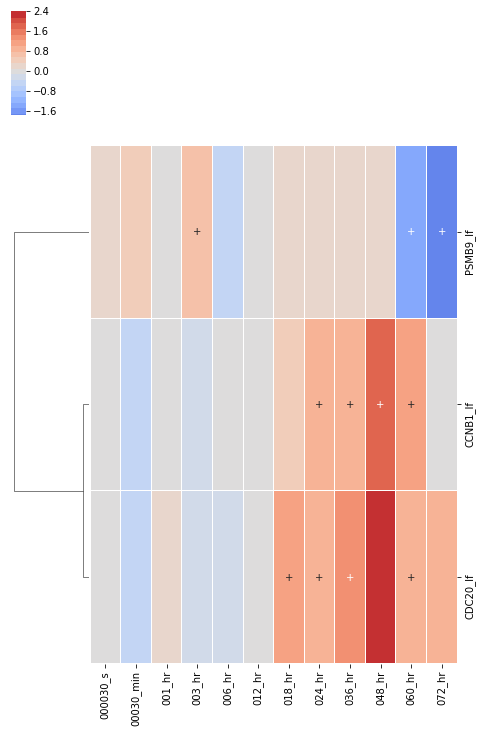

In [54]:

expand_neigh = net_sub.expand_neighbors(
    network=None,
    nodes=g2_m,
    downstream=True,
    upstream=True,
    max_dist=1,
    include_only=reactome_only.filter_multi(category=['label_free_up']).term_to_genes('cell cycle'),
    add_interconnecting_edges=False, 
)

expand_neigh = net_sub.paths_between_two_lists(
    reactome_only.filter_multi(category=['ph_silac_up']).term_to_genes('dna repair'),
    g2_m,
    max_length=3,
    include_only=reactome_only.filter_multi(category=['label_free_up']).term_to_genes('cell cycle'),
    add_interconnecting_edges=True
)
print(len(expand_neigh.nodes))
print(len(expand_neigh.edges))
expand_neigh = utils.delete_disconnected_network(expand_neigh)
exp_data.label_free.heatmap(
    expand_neigh.nodes, 
    subset_index='identifier',
    index='label', 
    rank_index=False, 
    cluster_row=True,
    min_sig=3, 
    annotate_sig=True,
    linewidths=0.01
);

In [55]:
#expand_neigh = utils.add_attribute_to_network(expand_neigh, g2_m, 'color', 'red', 'white')
vis.draw_cyjs(
    expand_neigh, layout='dagre', 
    spacingFactor=1., 
    nodeRepulsion=100, gravity=.1, 
    rankDir='TB', nodeSep=5, rankSep=25, ranker='longest-path'
)

In [56]:
expand_neigh = net_sub.paths_between_two_lists(
    reactome_only.filter_multi(category=['ph_silac_up']).term_to_genes('dna repair'),
    g2_m,
    reverse=True,
    max_length=3,
    include_only=exp_data.species.sig,
    add_interconnecting_edges=False
)

expand_neigh = utils.delete_disconnected_network(expand_neigh)

print(len(expand_neigh.nodes))
print(len(expand_neigh.edges))

Removing from list
29
38


In [57]:
vis.draw_cyjs(
    expand_neigh, layout='dagre', 
    spacingFactor=1., 
    nodeRepulsion=100, gravity=.1, 
    rankDir='TB', nodeSep=5, rankSep=25, ranker='longest-path'
)

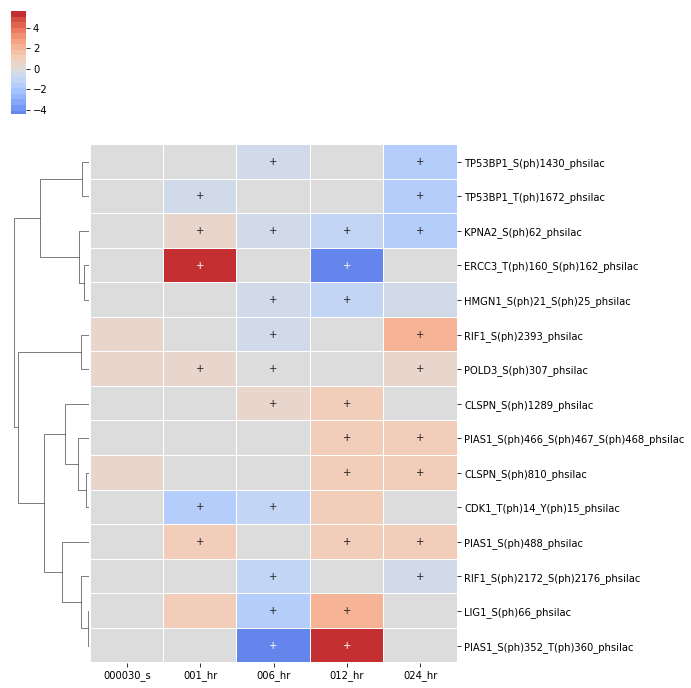

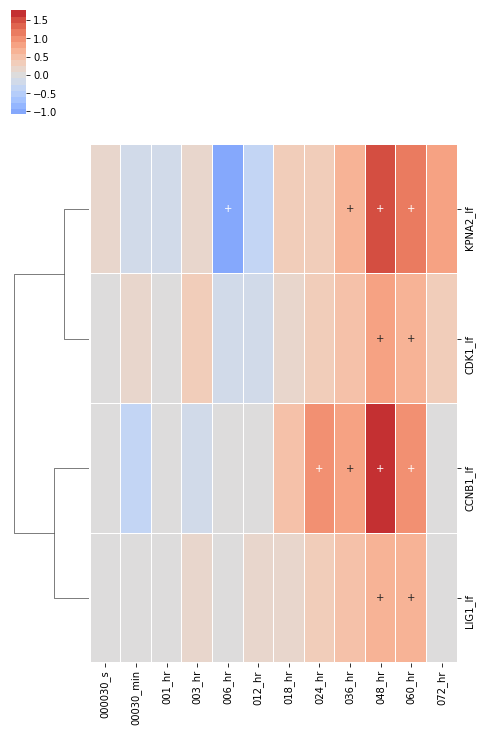

In [58]:
exp_data.ph_silac.heatmap(
    expand_neigh.nodes, 
    subset_index='identifier',
    index='label', 
    rank_index=False, 
    cluster_row=True,
    min_sig=2, 
    linewidths=0.01
);

exp_data.label_free.heatmap(
    expand_neigh.nodes, 
    subset_index='identifier',
    index='label', 
    rank_index=False, 
    cluster_row=True,
    min_sig=2, 
    linewidths=0.01
);

10
9


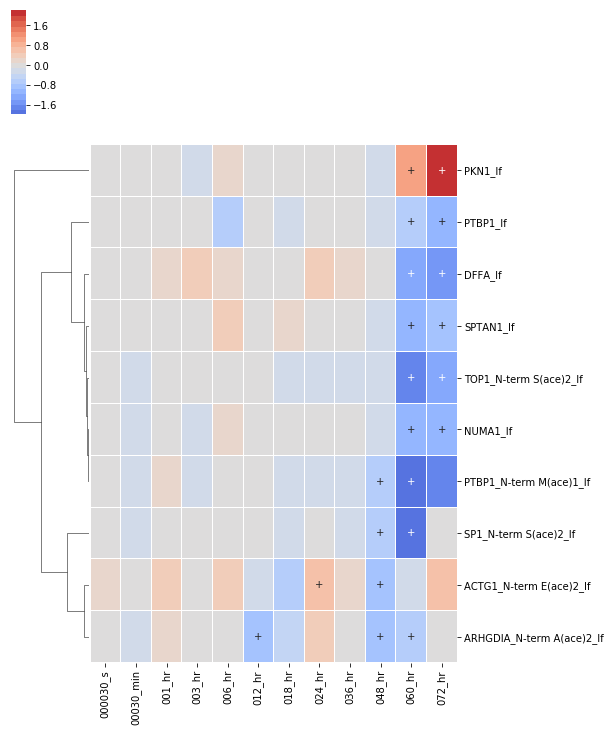

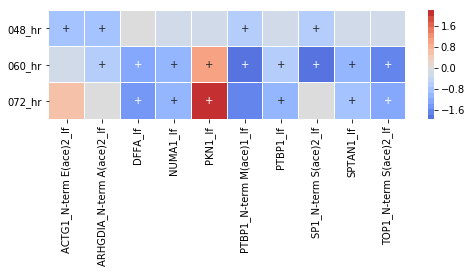

In [59]:
down_casp3 = net_sub.expand_neighbors(
    network=None, 
    nodes=['CASP3'], 
    upstream=False, downstream=True,
    max_dist=1,
    include_only=exp_data.label_free.sig.require_n_sig(index='label', n_sig=2).id_list
)
down_casp3 = utils.delete_disconnected_network(down_casp3)
print(len(down_casp3.nodes))
print(len(down_casp3.edges))
exp_data.label_free.heatmap(
    down_casp3.nodes, 
    subset_index='identifier', index='label', 
    min_sig=2, linewidths=0.01,
    cluster_row=True
);

exp_data.label_free.require_n_sig(index='label', n_sig=2).heatmap(
    down_casp3.nodes, subset_index='identifier', 
    #index='label', 
    rank_index=True,
    figsize=(8, 2),
    index='sample_id', columns='label',
    min_sig=2, linewidths=0.01, cluster_row=False, cluster_col=False
);
plt.yticks(rotation=0)
plt.savefig('down_from_casp3.png', dpi=300, bbox_inches='tight')

In [60]:
vis.draw_cyjs(down_casp3)

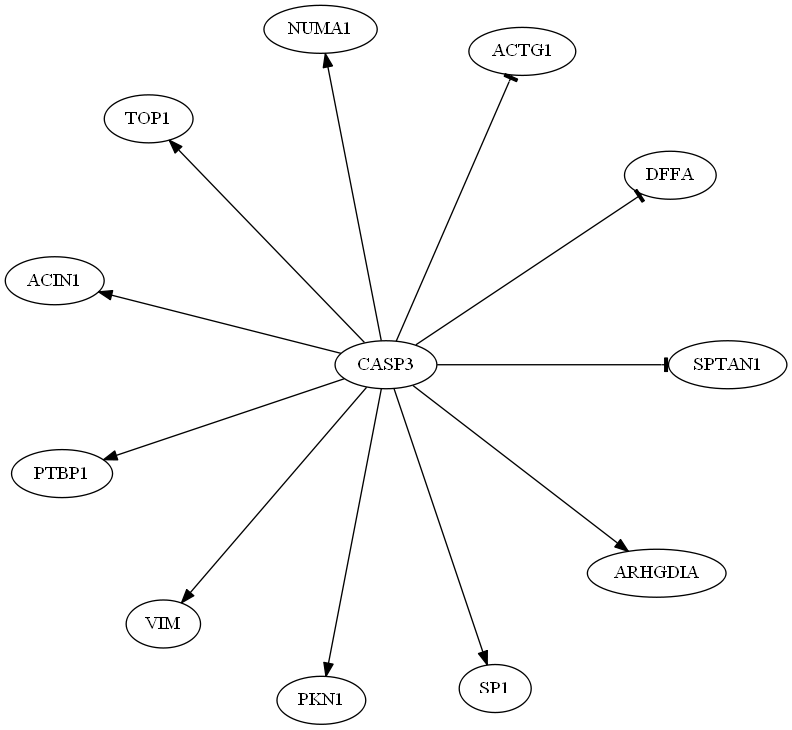

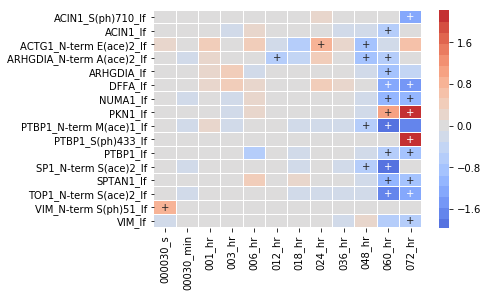

In [61]:
def show_neighbors(node, df, upstream=True, downstream=False, max_dist=1, 
                   include_only=None, figsize=None):
    
    df_copy = df.copy()
    df_copy.require_n_sig(n_sig=1, inplace=True)

    neighbors = net_sub.expand_neighbors(
        network=None, 
        nodes=[node],
        upstream=upstream, 
        downstream=downstream, 
        max_dist=max_dist,
        include_only=include_only
    )
    
    neighbors = utils.delete_disconnected_network(neighbors)
    s_name =  'node_{}.png'.format(node)
    exporters.export_to_dot(neighbors, s_name, image_format='png', engine='circo')
    display(Image(s_name, width=400))

    g = df_copy.heatmap(
        sorted(neighbors.nodes),
        subset_index='identifier', 
        index='label', 
        min_sig=1, 
        rank_index=True, 
        linewidths=0.01,
        figsize=figsize
    );
    
    g.savefig('{}_heatmap.png'.format(node), bbox_inches='tight', dpi=300)
show_neighbors('CASP3', exp_data.label_free, False, True, max_dist=1,
              include_only=exp_data.label_free.sig.require_n_sig(n_sig=2).id_list)

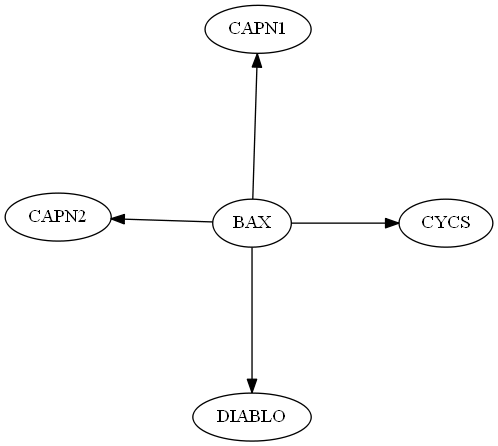

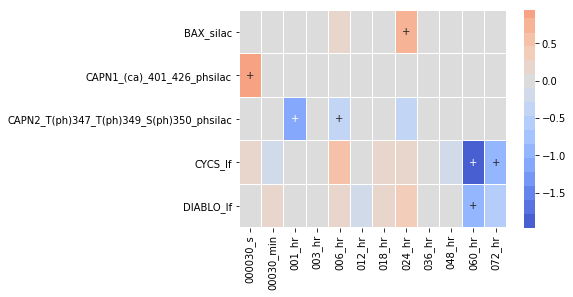

In [62]:
show_neighbors('BAX', exp_data.species, False, True,  max_dist=1,
              include_only=exp_data.species.sig.require_n_sig(n_sig=1).id_list)

## Exploring label free enrichment

Number of rows went from 156 to 35
Number of rows went from 35 to 35


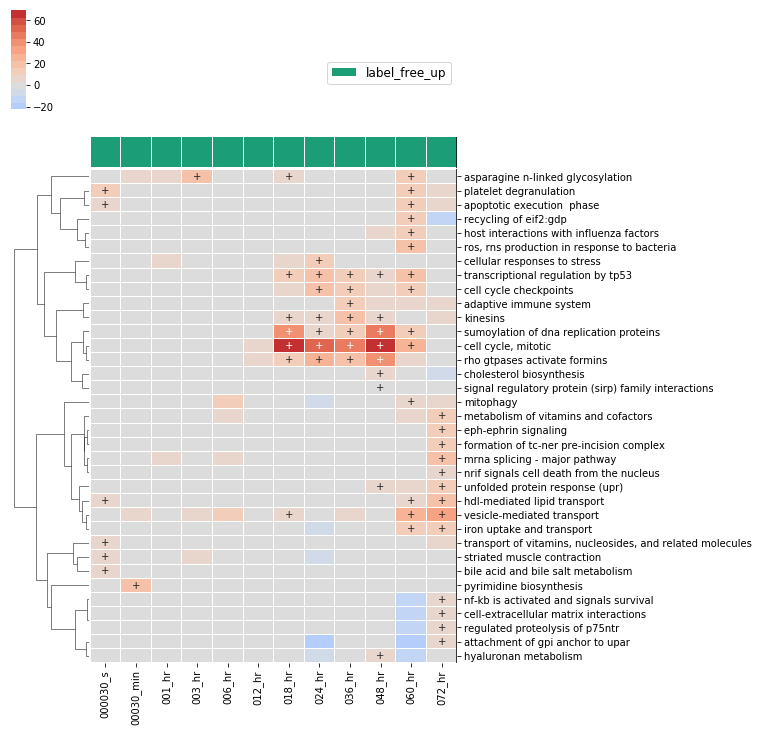

In [63]:
subset = reactome_only.filter_multi(
    category=['label_free_up', ]#'label_free_down']
)

at_least_2 = subset.require_n_sig(
    columns='sample_id',
    index=['term_name', 'category'],
    n_sig=1
)


at_least_2.remove_redundant(inplace=True, level='dataframe')
at_least_2.remove_redundant(inplace=True, level='sample')


at_least_2.heatmap(
    convert_to_log=False,
    columns=['category', 'sample_id'],
    cluster_row=True, 
    annotate_sig=True, 
    figsize=(8, 12),
    linewidths=0.01
);
plt.savefig('label_free_enriched_terms.png', dpi=300, bbox_inches='tight')

In [64]:
sorted(enrichment_array.db.unique())

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'BioCarta_2016',
 'BioPlex_2017',
 'Cancer_Cell_Line_Encyclopedia',
 'ChEA_2016',
 'DrugMatrix',
 'Drug_Perturbations_from_GEO_2014',
 'ENCODE_Histone_Modifications_2015',
 'ENCODE_TF_ChIP-seq_2015',
 'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X',
 'ESCAPE',
 'Enrichr_Submissions_TF-Gene_Coocurrence',
 'Epigenomics_Roadmap_HM_ChIP-seq',
 'GO_Biological_Process_2017b',
 'GO_Cellular_Component_2017b',
 'GO_Molecular_Function_2017b',
 'Genome_Browser_PWMs',
 'Human_Gene_Atlas',
 'Human_Phenotype_Ontology',
 'Jensen_COMPARTMENTS',
 'Jensen_DISEASES',
 'Jensen_TISSUES',
 'KEA_2015',
 'KEGG_2016',
 'Kinase_Perturbations_from_GEO_down',
 'Kinase_Perturbations_from_GEO_up',
 'LINCS_L1000_Chem_Pert_down',
 'LINCS_L1000_Chem_Pert_up',
 'LINCS_L1000_Kinase_Perturbations_down',
 'LINCS_L1000_Kinase_Perturbations_up',
 'LINCS_L1000_Ligand_Per

Number of rows went from 39 to 39
Number of rows went from 39 to 39


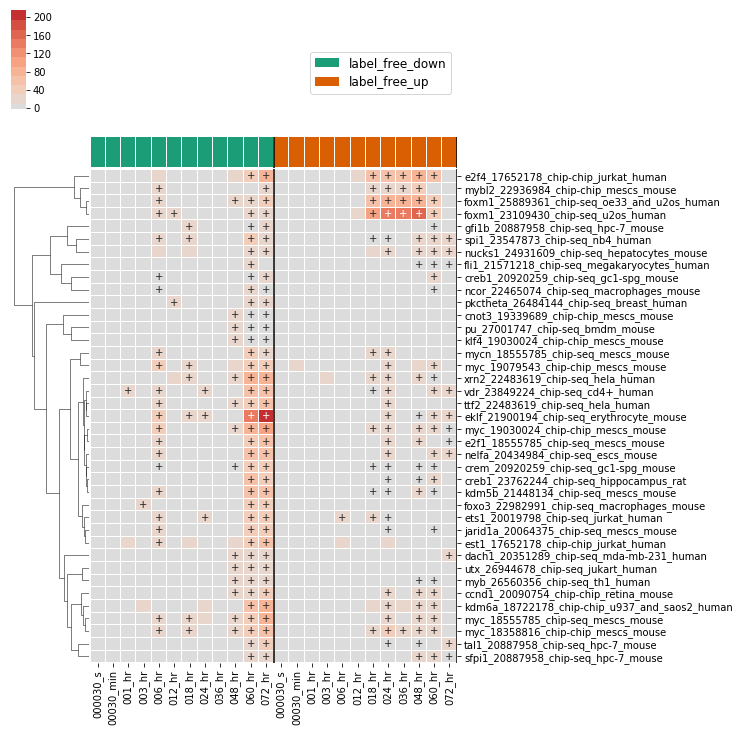

In [65]:
subset = enrichment_array.filter_multi(
    category=['label_free_up', 'label_free_down' ],
    db=['ChEA_2016']
)

at_least_2 = subset.require_n_sig(
    columns='sample_id',
    index=['term_name', 'category'],
    n_sig=3
)


at_least_2.remove_redundant(inplace=True, level='dataframe')
at_least_2.remove_redundant(inplace=True, level='sample')


at_least_2.heatmap(
    convert_to_log=False,
    columns=['category', 'sample_id'],
    cluster_row=True, 
    annotate_sig=True, 
    figsize=(8, 12),
    linewidths=0.01
);
plt.savefig('label_free_enriched_terms.png', dpi=300, bbox_inches='tight')